In [3]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt 


import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS 
from sklearn.linear_model import LassoCV
import scipy.stats as stats


import warnings


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Expedia Personalization Exploration
## Import and prepare data

In [4]:
df = pd.read_csv("data/train.csv")
df['date'] = pd.to_datetime(df['date_time']).dt.date # Create Date column for fuzzier matching
df = df[df['random_bool'] == 0] # Only keep real data
df

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,date
60,6,2013-06-05 12:27:51,14,100,NaN,NaN,100,10759,0,2.0,0,1.95,NaN,0.00,4,97.63,0,21106,1,5,2,0,1,0,NaN,652.84,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2013-06-05
61,6,2013-06-05 12:27:51,14,100,NaN,NaN,100,22135,0,5.0,0,1.95,NaN,0.00,6,115.03,0,21106,1,5,2,0,1,0,NaN,652.84,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2013-06-05
62,6,2013-06-05 12:27:51,14,100,NaN,NaN,100,52376,2,0.0,1,1.95,NaN,0.00,2,86.03,0,21106,1,5,2,0,1,0,NaN,652.85,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2013-06-05
63,6,2013-06-05 12:27:51,14,100,NaN,NaN,100,104251,3,4.0,1,1.95,NaN,0.00,1,145.00,0,21106,1,5,2,0,1,0,NaN,652.84,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,162.38,1,2013-06-05
64,6,2013-06-05 12:27:51,14,100,NaN,NaN,100,118866,2,4.5,1,1.95,NaN,0.00,3,183.66,0,21106,1,5,2,0,1,0,NaN,652.78,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2013-06-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9917525,665574,2013-05-21 11:06:37,24,216,NaN,NaN,117,32019,4,3.5,0,2.48,0.0551,4.53,2,66.07,0,19246,2,7,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,1.0,0.0,22.0,1.0,0.0,127.0,-1.0,0.0,27.0,1.0,0.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2013-05-21
9917526,665574,2013-05-21 11:06:37,24,216,NaN,NaN,117,33959,4,3.0,1,2.20,0.3344,4.39,6,67.10,0,19246,2,7,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,16.0,1.0,0.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,154.34,1,2013-05-21
9917527,665574,2013-05-21 11:06:37,24,216,NaN,NaN,117,35240,4,0.0,0,1.79,NaN,4.64,8,73.91,0,19246,2,7,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,1.0,0.0,55.0,0.0,0.0,NaN,0.0,0.0,16.0,0.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2013-05-21
9917528,665574,2013-05-21 11:06:37,24,216,NaN,NaN,117,94437,4,0.0,0,2.94,0.0928,4.64,7,66.07,0,19246,2,7,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,1.0,0.0,43.0,1.0,0.0,43.0,-1.0,0.0,12.0,-1.0,0.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2013-05-21


In [ ]:
df.columns

## Filter df to get "same searches"

In [5]:
duplicatedMask = df.duplicated(subset=['date','srch_destination_id', 'prop_id',
                                       'srch_length_of_stay','srch_booking_window'], 
                               keep=False)
dup = df[duplicatedMask] # All rows with duplicates where the 5 parameters are exactly the same
dup # Unique rows are dropped

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,date
498,45,2013-05-18 09:25:08,14,100,NaN,NaN,219,2924,4,4.5,1,2.30,0.0499,5.27,3,174.11,0,10948,1,0,2,0,1,1,NaN,NaN,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,2013-05-18
499,45,2013-05-18 09:25:08,14,100,NaN,NaN,219,25444,4,4.0,1,2.30,0.0860,5.02,9,174.11,0,10948,1,0,2,0,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,2013-05-18
500,45,2013-05-18 09:25:08,14,100,NaN,NaN,219,31792,2,4.0,1,2.08,0.0085,4.68,13,102.13,0,10948,1,0,2,0,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,9.0,0,NaN,0,2013-05-18
501,45,2013-05-18 09:25:08,14,100,NaN,NaN,219,34700,2,3.0,1,2.77,0.0027,4.58,16,87.54,0,10948,1,0,2,0,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,2013-05-18
502,45,2013-05-18 09:25:08,14,100,NaN,NaN,219,38213,0,4.0,0,0.69,0.0019,4.52,21,68.09,0,10948,1,0,2,0,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2013-05-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9916418,665500,2012-12-22 06:55:24,5,219,NaN,NaN,219,80475,3,4.5,0,5.65,0.1359,5.82,22,161.00,0,4562,1,14,2,0,1,1,NaN,183.97,0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2012-12-22
9916419,665500,2012-12-22 06:55:24,5,219,NaN,NaN,219,98736,4,4.5,1,5.63,0.0879,5.92,25,143.00,1,4562,1,14,2,0,1,1,NaN,185.19,0,NaN,NaN,NaN,1.0,0.0,11.0,1.0,0.0,13.0,1.0,0.0,25.0,0.0,0.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,10.0,0,NaN,0,2012-12-22
9916420,665500,2012-12-22 06:55:24,5,219,NaN,NaN,219,110940,3,0.0,0,5.74,0.0695,5.39,18,105.00,0,4562,1,14,2,0,1,1,NaN,184.51,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2012-12-22
9916424,665500,2012-12-22 06:55:24,5,219,NaN,NaN,219,126657,4,4.0,1,5.96,0.1755,6.02,14,199.00,1,4562,1,14,2,0,1,1,NaN,184.56,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,2012-12-22


In [6]:
dupGroups = dup.groupby(['date','srch_destination_id', 'prop_id',
                         'srch_length_of_stay','srch_booking_window'])[['price_usd', 'position']].agg(
                                    ['median', 'std', 'mean', 'count', 'min', 'max'])
dupGroups['range'] = dupGroups['price_usd']['max'] - dupGroups['price_usd']['min']
dupGroups # Group by the aforementioned criteria

price_usd  \
                                                                                  median   
date       srch_destination_id prop_id srch_length_of_stay srch_booking_window             
2012-11-01 4562                21155   1                   1                      309.00   
                               25075   1                   1                      259.00   
                               34036   1                   1                      200.00   
                               41278   1                   0                      499.63   
                               53204   1                   1                      135.00   
...                                                                                  ...   
2013-06-30 11230               118327  1                   1                      107.00   
                               122691  1                   1                      174.00   
                               125320  1                   1                       89.00   
                               135372  1                   1                       75.00   
                               138986  1                   1                      154.00   

                                                                                           \
                                                                                      std   
date       srch_destination_id prop_id srch_length_of_stay srch_booking_window              
2012-11-01 4562                21155   1                   1                    14.142136   
                               25075   1                   1                     0.000000   
                               34036   1                   1                     0.000000   
                               41278   1                   0                     0.890955   
                               53204   1                   1                     0.000000   
...                                                                                   ...   
2013-06-30 11230               118327  1                   1                     0.000000   
                               122691  1                   1                     7.071068   
                               125320  1                   1                     0.000000   
                               135372  1                   1                     0.000000   
                               138986  1                   1                     0.000000   

                                                                                        \
                                                                                  mean   
date       srch_destination_id prop_id srch_length_of_stay srch_booking_window           
2012-11-01 4562                21155   1                   1                    309.00   
                               25075   1                   1                    259.00   
                               34036   1                   1                    200.00   
                               41278   1                   0                    499.63   
                               53204   1                   1                    135.00   
...                                                                                ...   
2013-06-30 11230               118327  1                   1                    107.00   
                               122691  1                   1                    174.00   
                               125320  1                   1                     89.00   
                               135372  1                   1                     75.00   
                               138986  1                   1                    154.00   

                                                                                      \
                                                                               count   
date       srch_destination_id prop_id srch_length

In [7]:
dupGroups.to_csv('grouped.csv')

Max number of duplicates:  4


Text(0.5, 0, '# of "identical" searches')

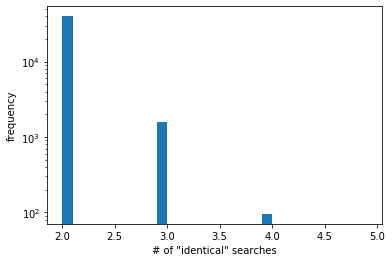

In [8]:
dupCount = dupGroups['price_usd']['count']
print("Max number of duplicates: ", max(dupCount))
bins = np.arange(dupCount.min(), dupCount.max() + 1, 0.1)
plt.hist(dupCount, bins=bins)
plt.yscale('log')
plt.ylabel('frequency')
plt.xlabel('# of "identical" searches')

Maximum Range:  205305.0


Text(0.5, 0, 'maximum amount difference in group')

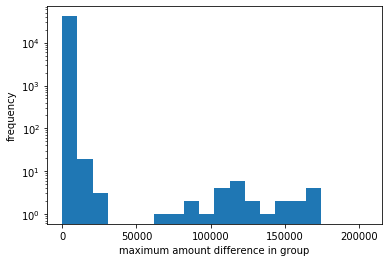

In [9]:
dupRange = dupGroups['price_usd']['max'] - dupGroups['price_usd']['min']
print("Maximum Range: ", max(dupRange))
plt.hist(dupRange, bins=np.arange(dupRange.min(), dupRange.max() + 1, (dupRange.max() - dupRange.min()) // 20))
plt.yscale('log')
plt.ylabel('frequency')
plt.xlabel('maximum amount difference in group')

Maximum Range:  24131.0


Text(0.5, 0, 'maximum amount difference in group (filtered)')

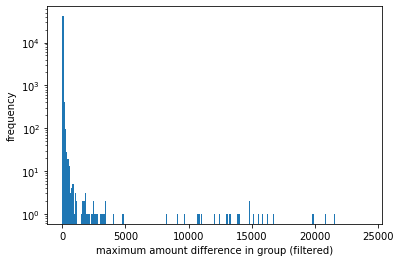

In [10]:
dupNoOutliers = dupGroups[dupGroups['range'] < 50000.0]['range']
print("Maximum Range: ", max(dupNoOutliers))
plt.hist(dupNoOutliers, bins=np.arange(dupNoOutliers.min(), 
                                       dupNoOutliers.max() + 1, 
                                       100))
plt.yscale('log')
plt.ylabel('frequency')
plt.xlabel('maximum amount difference in group (filtered)')

## Personalized Ranking and Price Relationship

In [11]:
dupGroups.loc[dupGroups.index[0]]

price_usd  median    309.000000
           std        14.142136
           mean      309.000000
           count       2.000000
           min       299.000000
           max       319.000000
position   median      3.000000
           std         0.000000
           mean        3.000000
           count       2.000000
           min         3.000000
           max         3.000000
range                 20.000000
Name: (2012-11-01, 4562, 21155, 1, 1), dtype: float64

In [12]:
price_dev, position_dev = [], []
price_dev_n, position_dev_n = [], []

for i, row in dup.iterrows():
    target = dupGroups.loc[(row['date'], row['srch_destination_id'], row['prop_id'], 
                        row['srch_length_of_stay'], row['srch_booking_window'])]
    
    priceDev = row['price_usd'] - target['price_usd']['mean']
    price_dev.append(priceDev)
    price_dev_n.append(priceDev / target['price_usd']['std'])
    
    posiDev = row['position'] - target['position']['mean']
    position_dev.append(posiDev)
    position_dev_n.append(posiDev / target['position']['std']) 

### Job 1: correlation between deviations

Text(0.5, 1.0, 'Deviation from group mean')

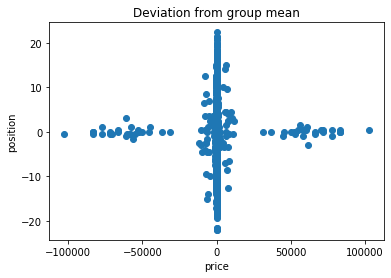

In [13]:
plt.scatter(price_dev, position_dev)
plt.xlabel('price')
plt.ylabel('position')
plt.title('Deviation from group mean')

### Job 2: correlation between normalized deviations

Text(0.5, 1.0, 'Normalized deviation from group mean')

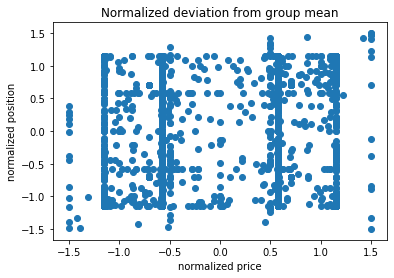

In [14]:
plt.scatter(price_dev_n, position_dev_n)
plt.xlabel('normalized price')
plt.ylabel('normalized position')
plt.title('Normalized deviation from group mean')

In [17]:
# average price per search id for minimum number of search results
# dup.groupby('srch_id')[['price_usd']].agg('mean')
dupGroups = dup.groupby(['date','srch_destination_id', 'prop_id',
                         'srch_length_of_stay','srch_booking_window', 'srch_id'])[['price_usd', 'position']].agg(
                                    ['median', 'std', 'mean', 'count', 'min', 'max'])
dupGroups['range'] = dupGroups['price_usd']['max'] - dupGroups['price_usd']['min']
dupGroups # Group by the aforementioned criteria

price_usd  \
                                                                                          median   
date       srch_destination_id prop_id srch_length_of_stay srch_booking_window srch_id             
2012-11-01 4562                21155   1                   1                   20703       319.0   
                                                                               535818      299.0   
                               25075   1                   1                   20703       259.0   
                                                                               535818      259.0   
                               34036   1                   1                   20703       200.0   
...                                                                                          ...   
2013-06-30 11230               125320  1                   1                   338771       89.0   
                               135372  1                   1                   248632       75.0   
                                                                               338771       75.0   
                               138986  1                   1                   248632      154.0   
                                                                               338771      154.0   

                                                                                            \
                                                                                       std   
date       srch_destination_id prop_id srch_length_of_stay srch_booking_window srch_id       
2012-11-01 4562                21155   1                   1                   20703   NaN   
                                                                               535818  NaN   
                               25075   1                   1                   20703   NaN   
                                                                               535818  NaN   
                               34036   1                   1                   20703   NaN   
...                                                                                     ..   
2013-06-30 11230               125320  1                   1                   338771  NaN   
                               135372  1                   1                   248632  NaN   
                                                                               338771  NaN   
                               138986  1                   1                   248632  NaN   
                                                                               338771  NaN   

                                                                                               \
                                                                                         mean   
date       srch_destination_id prop_id srch_length_of_stay srch_booking_window srch_id          
2012-11-01 4562                21155   1                   1                   20703    319.0   
                                                                               535818   299.0   
                               25075   1                   1                   20703    259.0   
                                                                               535818   259.0   
                               34036   1                   1                   20703    200.0   
...                                                                                       ...   
2013-06-30 11230               125320  1                   1                   338771    89.0   
                               135372  1                   1                   248632    75.0   
                                                                               338771    75.0   
                               138986  1                   1                   248632   154.0   
                                                                               338771   154.0   

          